In [3]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
def read_jsonl(path):
    """Parse jsonl to list of dicts"""
    with open(path) as f:
        lines = f.readlines()
    return [json.loads(line) for line in lines]


def get_signatures(ap_results):
    """Given the author profile results get all signatures"""
    signatures = []
    for profile in ap_results:
        signatures += profile['signatureIds']
    return signatures


def fill_dmatrix(distances, signature_list):
    """Given distances jsonl and list of signatures fill the distance matrix"""
    dmatrix = np.zeros(shape=(len(signature_list), len(signature_list)))

    signature_to_idx = {
        signature: idx for idx, signature in enumerate(signature_list)
    }

    for distance in distances:
        sig1 = distance['signatureId1']
        sig2 = distance['signatureId2']
        d = distance['distance']
        row = signature_to_idx[sig1]
        column = signature_to_idx[sig2]
        dmatrix[row, column] = d

    dmatrix = dmatrix.T + dmatrix # Transpose to fill symetric elements
    return dmatrix, signature_to_idx


def get_features(sig_id, features):
    """Retrieve all feature vectors realated to the given signature"""
    feature_vectors = []
    for feature_entry in features:
        if feature_entry['signatureId1'] == sig_id or feature_entry['signatureId2'] == sig_id:
            feature_vectors.append(feature_entry['features'])
    return feature_vectors

## Group name: "cmavergames"

### Illustrating the distance matrix

In [5]:
AUTHOR_PATH = '../data/cmavergames/'

In [6]:
ap_results = read_jsonl(path=os.path.join(AUTHOR_PATH, 'results.json'))
distances = read_jsonl(path=os.path.join(AUTHOR_PATH, 'distances.json'))
signatures = get_signatures(ap_results)
dmatrix, signature_to_idx = fill_dmatrix(distances, signatures)

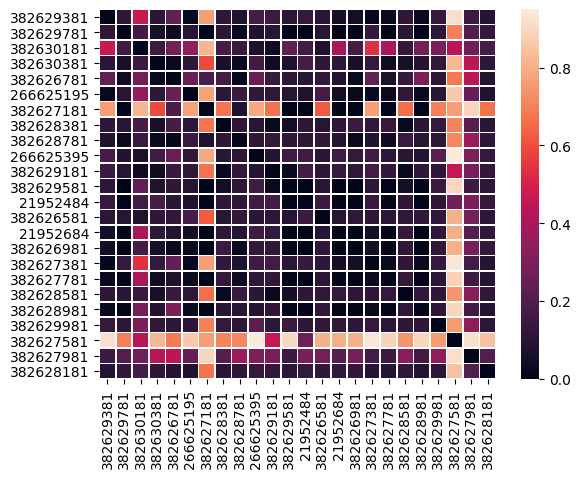

In [7]:
sns.heatmap(dmatrix, linewidths=0.5, xticklabels=signatures, yticklabels=signatures)
plt.show()

### Correlating features with distance

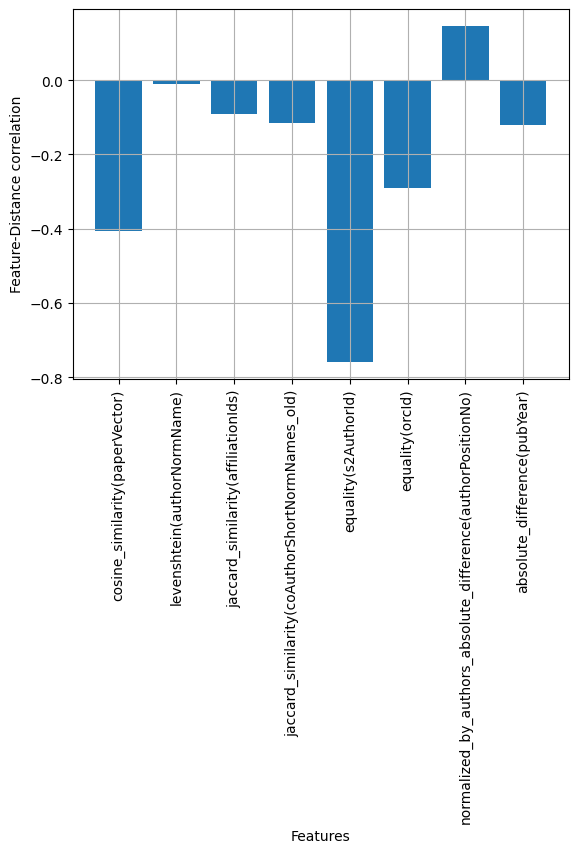

In [8]:
features = read_jsonl(path=os.path.join(AUTHOR_PATH, 'features.json'))
features = np.asarray([feature_entry['features'] for feature_entry in features])

distances = read_jsonl(path=os.path.join(AUTHOR_PATH, 'distances.json'))
distances = np.asarray([distance_entry['distance'] for distance_entry in distances])

feature_distance_corr = []
for i in range(0, 8):
    # Get correlation of selected feature and distance
    corr = np.corrcoef(x=features[:, i].astype(np.float), y=distances)[-1, 0]
    if np.isnan(corr):
        features[:, i][features[:, i] == 'NaN'] = 0
        corr = np.corrcoef(x=features[:, i].astype(np.float), y=distances)[-1, 0]
    feature_distance_corr.append(corr)

feature_names = [
    'cosine_similarity(paperVector)',
    'levenshtein(authorNormName)',
    'jaccard_similarity(affiliationIds)',
    'jaccard_similarity(coAuthorShortNormNames_old)',
    'equality(s2AuthorId)',
    'equality(orcId)',
    'normalized_by_authors_absolute_difference(authorPositionNo)',
    'absolute_difference(pubYear)'
]

plt.bar(range(len(feature_distance_corr)), feature_distance_corr)
plt.grid()
plt.xlabel('Features')
plt.ylabel('Feature-Distance correlation')
plt.xticks(range(len(feature_distance_corr)), feature_names, rotation=90)
plt.show()

In [9]:
# Lets check the average value of the most correlated continuous feature (cosine similarity of embeddings) for two rows
# One low distance row and one high distance row. Signature 382627581 is a high distance row and signature
# 382627781 is a low distance row

features = read_jsonl(path=os.path.join(AUTHOR_PATH, 'features.json'))

avg_cos_sim_high_d = np.average(
    [
        feature[0] for feature in get_features(sig_id=382627581, features=features)
    ]
)

avg_cos_sim_low_d = np.average(
    [
        feature[0] for feature in get_features(sig_id=382627781, features=features)
    ]
)

print(f'Average cos sim for high distance row: {avg_cos_sim_high_d}')
print(f'Average cos sim for low distance row: {avg_cos_sim_low_d}')

Average cos sim for high distance row: 0.31993804891304345
Average cos sim for low distance row: 0.5343430391304347


### Checking different clustering approaches

For DBSCAN we have optimal hyperparams:

* eps: 0.8025
* min samples: 2

For Agglomerative clustering we have optimal hyperparams:

* distance threshold: 0.52502

In [10]:
from sklearn.cluster import DBSCAN

clusterer = DBSCAN(eps=0.08025, min_samples=2, metric='precomputed')
profiles = clusterer.fit_predict(dmatrix)
_, counts = np.unique(profiles, return_counts=True)
print(f'DBSCAN returns {len(counts) + counts[0] -1} author profiles')
print(counts)

DBSCAN returns 5 author profiles
[ 4 20]


In [11]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(
                n_clusters=None,
                affinity='precomputed',
                distance_threshold=0.52502,
                linkage='average'
)
profiles = clusterer.fit_predict(dmatrix)
_, counts = np.unique(profiles, return_counts=True)
print(f'AgglomerativeClustering returns {len(counts)} author profiles')
print(counts)

AgglomerativeClustering returns 2 author profiles
[23  1]


In [12]:
import onnxruntime as rt

x = np.asarray([
    [0.3331656,0.0,0.0,0.25,np.nan,np.nan,0.75,3.0],
    [0.3331656,0.0,0.0,0.25,False,np.nan,0.75,3.0],
    [0.3331656,0.0,0.0,0.25,False,np.nan,0.75,3.0],
    [0.3331656,0.0,0.0,0.25,False,False,0.75,3.0],
    [0.3331656,0.0,0.0,0.25,False,True,0.75,3.0]
]).astype(np.float32)

sess = rt.InferenceSession('../models/lightgbm.onnx')
y_onnx = sess.run(None, {"input": x})
y_onnx

[array([0, 0, 0, 0, 1], dtype=int64),
 [{0: 0.8083599209785461, 1: 0.19164007902145386},
  {0: 0.8083599209785461, 1: 0.19164007902145386},
  {0: 0.8083599209785461, 1: 0.19164007902145386},
  {0: 0.8403158187866211, 1: 0.1596841812133789},
  {0: 0.222592294216156, 1: 0.777407705783844}]]